In [2]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\eklun\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
df = pd.read_csv('./data/imdb_sup.csv')
#df = df.sample(frac=0.1, replace=False, random_state=1)
df.info()
df = df.drop('Sentiment', axis=1)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     50000 non-null  object
 1   Rating     50000 non-null  int64 
 2   Sentiment  50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


,Review,Rating
0,"Kurt Russell's chameleon-like performance, cou...",10
1,It was extremely low budget(it some scenes it ...,8
2,James Cagney is best known for his tough chara...,8
3,"Following the brilliant ""Goyôkiba"" (aka. ""Hanz...",8
4,One of the last classics of the French New Wav...,10


In [4]:
df = df.drop_duplicates(keep="first",subset=["Review"])


In [5]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def clean_text(text):
    doc = nlp(text)
    text = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return " ".join(text)

In [6]:
df['Clean_Review'] = df['Review'].apply(clean_text)
df.head()

,Review,Rating,Clean_Review
0,"Kurt Russell's chameleon-like performance, cou...",10,Kurt Russell chameleon like performance couple...
1,It was extremely low budget(it some scenes it ...,8,extremely low scene look like record home vide...
2,James Cagney is best known for his tough chara...,8,James Cagney well know tough gangster role pla...
3,"Following the brilliant ""Goyôkiba"" (aka. ""Hanz...",8,follow brilliant Goyôkiba aka Hanzo Razor Swor...
4,One of the last classics of the French New Wav...,10,classic French New Wave direction cineaste Jea...


In [7]:
df_first_five = df.head(n=5)

tmp = df_first_five.reset_index(drop=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', 200)

tmp



,Review,Rating,Clean_Review
0,"Claire Booth Luce's ""The Women"" shows relationships with men through a woman's point of view in a play, (and 1939 film that also has Joan Crawford playing a bitch: a character who might have been ...",7,Claire Booth Luce Women show relationship man woman point view play film Joan Crawford play bitch character Amanda Farrow year male character male character bunch use woman like toy throw away lea...
1,"_The Wild Life_ has an obvious resemblance to _Fast Times At Ridgemont High_, and _The Wild Life_ comes up short.<br /><br />------------ <br /><br />Some other stan wrote the above comment. Of co...",7,Wild Life obvious resemblance Fast Times Ridgemont High Wild Life come br stan write comment course Wild Life Ridgemont Ridgemont quintessential flica Wild Life enjoyable whiny mindless movie mind...
2,"This was the film that first indicated to me what a great actor Martin Sheen really is. He modestly claims that Charlie is a better actor, Charlie can't hold a candle to him.<br /><br />I found it...",8,film indicate great actor Martin Sheen modestly claim Charlie well actor Charlie hold candle find suspenseful thoroughly enjoy intertwining love story main plot usually hate love story great plot ...
3,"The plot has already been described by other reviewers, so I will simply add that my reason for wanting to see this film was to see Gabrielle Drake in all her undoubted glory.<br /><br />Miss Drak...",4,plot describe reviewer simply add reason want film Gabrielle Drake undoubted Drake sexy prettiest example posh totty commit celluloid era ilk equally exquisite Jane Asher come close actress musica...
4,Most of the comments have been positive but I would like to add that viewers should also focus on the sets. The set designer used a lot of beautiful art deco treatments along with beautiful buildi...,10,comment positive like add viewer focus set set designer lot beautiful art deco treatment beautiful building stair door furniture forth worth pay attention movie drive characterization symbolism ri...


In [7]:
sia = SentimentIntensityAnalyzer()

df['Sentiments'] = df['Review'].apply(lambda x: sia.polarity_scores(x))
df = pd.concat([df.drop(['Sentiments'], axis=1), df['Sentiments'].apply(pd.Series)], axis=1)

df.head()

,Review,Rating,Clean_Review,neg,neu,pos,compound
0,"Kurt Russell's chameleon-like performance, cou...",10,Kurt Russell chameleon like performance couple...,0.000,0.898,0.102,0.7909
1,It was extremely low budget(it some scenes it ...,8,extremely low scene look like record home vide...,0.162,0.730,0.108,-0.9494
2,James Cagney is best known for his tough chara...,8,James Cagney well know tough gangster role pla...,0.018,0.817,0.164,0.9965
3,"Following the brilliant ""Goyôkiba"" (aka. ""Hanz...",8,follow brilliant Goyôkiba aka Hanzo Razor Swor...,0.108,0.700,0.191,0.9922
4,One of the last classics of the French New Wav...,10,classic French New Wave direction cineaste Jea...,0.074,0.737,0.189,0.9697


In [8]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df['Clean_Review'].apply(lambda x: x.split(' ')))]
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)
doc2vec_df = df['Clean_Review'].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ['doc2vec_vector_' + str(x) for x in doc2vec_df.columns]
df = pd.concat([df, doc2vec_df], axis=1)

df.head()

,Review,Rating,Clean_Review,neg,neu,pos,compound,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
0,"Kurt Russell's chameleon-like performance, cou...",10,Kurt Russell chameleon like performance couple...,0.000,0.898,0.102,0.7909,0.348727,-0.283106,0.060187,-0.498162,0.079840
1,It was extremely low budget(it some scenes it ...,8,extremely low scene look like record home vide...,0.162,0.730,0.108,-0.9494,1.750372,0.311049,-0.240323,0.120756,-0.379363
2,James Cagney is best known for his tough chara...,8,James Cagney well know tough gangster role pla...,0.018,0.817,0.164,0.9965,0.313515,-0.327671,0.430811,-1.762936,-0.712429
3,"Following the brilliant ""Goyôkiba"" (aka. ""Hanz...",8,follow brilliant Goyôkiba aka Hanzo Razor Swor...,0.108,0.700,0.191,0.9922,-0.057222,-0.867865,-0.165273,-1.367896,0.873025
4,One of the last classics of the French New Wav...,10,classic French New Wave direction cineaste Jea...,0.074,0.737,0.189,0.9697,-0.114497,-0.256006,0.793574,-1.042057,0.514050


In [9]:
tfidf = TfidfVectorizer(min_df=10)
tfidf_result = tfidf.fit_transform(df['Clean_Review']).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names_out())
tfidf_df.columns = ['word_' + str(x) for x in tfidf_df.columns]
tfidf_df.index = df.index
df = pd.concat([df, tfidf_df], axis=1)



In [10]:
df['posneg'] = df['Rating'].apply(lambda x: 0 if x < 5 else 1)


In [11]:
df.info()
#df = df.drop(['Review', 'Clean_Review'], axis = 1)
target = df['posneg'].value_counts().reset_index()
target.rename(columns={'index':'posneg','posneg':'value'}, inplace=True)
target['percentage'] = round((target['count']/target['count'].sum())*100,2)
target

<class 'pandas.core.frame.DataFrame'>
Index: 49582 entries, 0 to 49999
Columns: 20190 entries, Review to posneg
dtypes: float32(5), float64(20181), int64(2), object(2)
memory usage: 7.5+ GB


,value,count,percentage
0,1,24884,50.19
1,0,24698,49.81


In [12]:
X = df.drop(['posneg','Rating'],axis = 1)
Y = df['posneg']
#Kolla hur X ser ur, eventuellt droppa Review o Clean_Review
#Eventuellt använda samma train/test split på alla classifiers

In [13]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, 
                                                    Y, test_size=0.25, 
                                                    random_state=42)

In [14]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train_rf, y_train_rf)
preds = model.predict(X_test_rf)

In [83]:
classification_decision1 = classification_report(y_test_rf, model.predict(X_test_rf))
print(classification_decision1)

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       593
           1       0.84      0.82      0.83       656

    accuracy                           0.82      1249
   macro avg       0.82      0.82      0.82      1249
weighted avg       0.82      0.82      0.82      1249



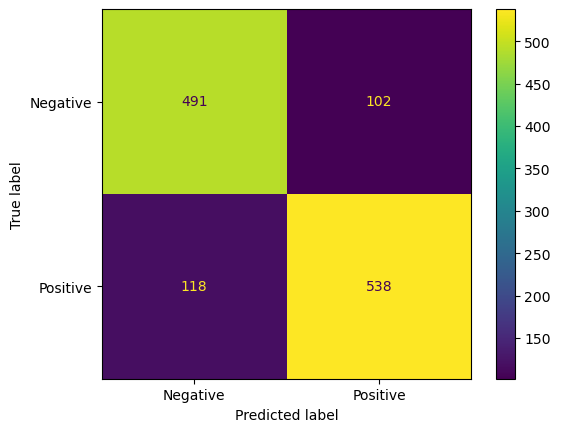

In [93]:
disp = ConfusionMatrixDisplay.from_estimator(model, X_test_rf, y_test_rf, display_labels=['Negative', 'Positive'])


In [94]:
X_train_lr, X_test_lr,y_train_lr,y_test_lr = train_test_split(X,
                                                Y,
                                                test_size = 0.3,
                                                random_state = 42)

In [96]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_lr, y_train_lr)
logreg.predict(X_test_lr)

LogisticRegression(random_state=42)

In [97]:
classification_decision2 = classification_report(y_test_lr, logreg.predict(X_test_lr))
print(classification_decision2)

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       722
           1       0.81      0.82      0.82       777

    accuracy                           0.81      1499
   macro avg       0.81      0.81      0.81      1499
weighted avg       0.81      0.81      0.81      1499



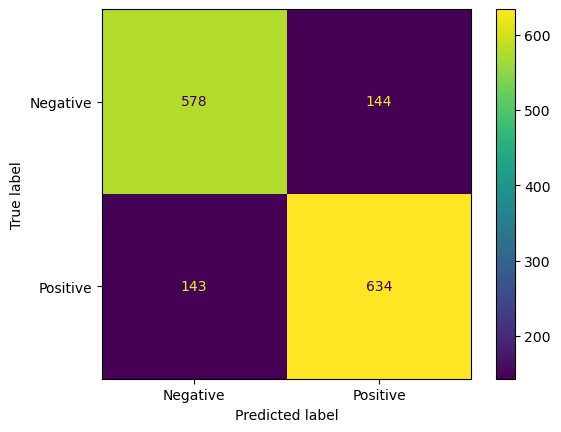

In [98]:
disp = ConfusionMatrixDisplay.from_estimator(logreg, X_test_lr, y_test_lr, display_labels=['Negative', 'Positive'])


In [101]:
X_train_mnb, X_test_mnb,y_train_mnb,y_test_mnb = train_test_split(X,
                                                Y,
                                                test_size = 0.3,
                                                random_state = 42)
from sklearn import svm
from sklearn.svm import LinearSVC

svc = LinearSVC(random_state=42).fit(X_train_mnb, y_train_mnb)
svc.predict(X_test_mnb)


In [102]:
classification_decision3 = classification_report(y_test_mnb, svc.predict(X_test_mnb))
print(classification_decision3)

              precision    recall  f1-score   support

           0       0.79      0.75      0.77       722
           1       0.78      0.82      0.80       777

    accuracy                           0.78      1499
   macro avg       0.78      0.78      0.78      1499
weighted avg       0.78      0.78      0.78      1499



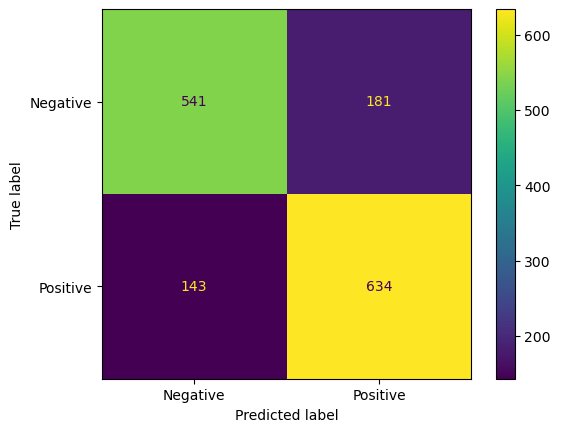

In [103]:
disp = ConfusionMatrixDisplay.from_estimator(svc, X_test_mnb, y_test_mnb, display_labels=['Negative', 'Positive'])
